<a href="https://colab.research.google.com/github/TaherLilywala/NNFL-Projects/blob/main/Image_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading Data

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

# defining the size of the image
SIZE = 160
color_img = []
path = '/content/drive/My Drive/NNFL Stuff/Image Colorization/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '1000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.resize(img, (SIZE, SIZE)) #resizing image
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = '/content/drive/My Drive/NNFL Stuff/Image Colorization/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '1000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

 14%|█▍        | 1000/7129 [04:31<29:41,  3.44it/s]

In [ ]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

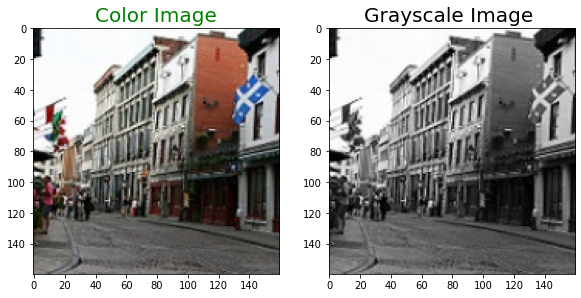

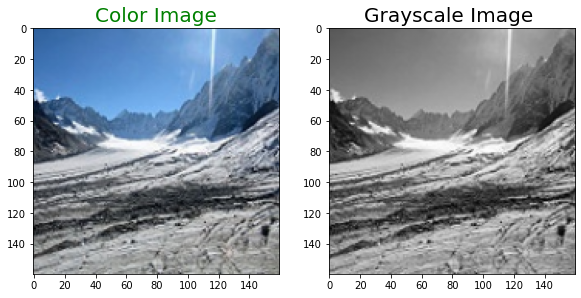

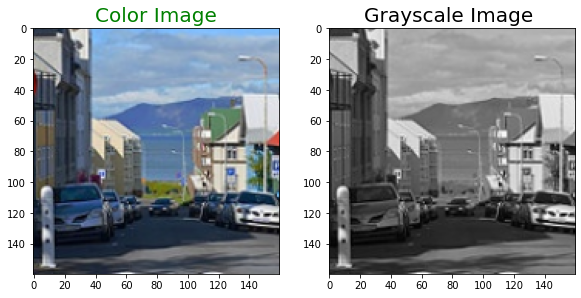

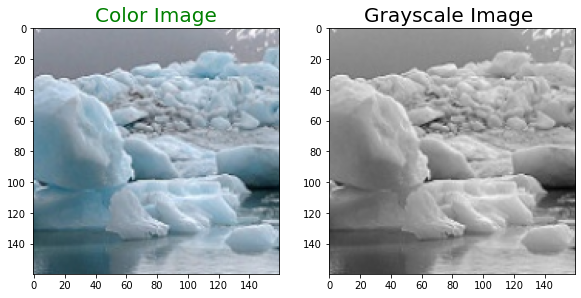

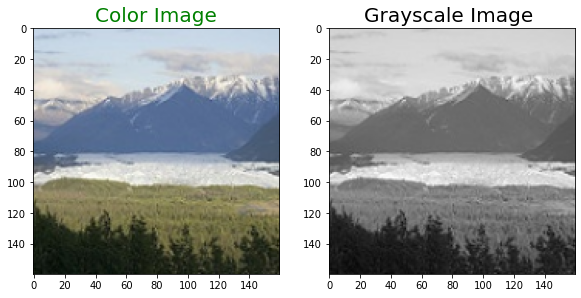

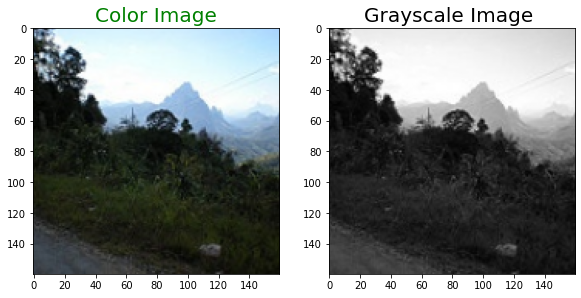

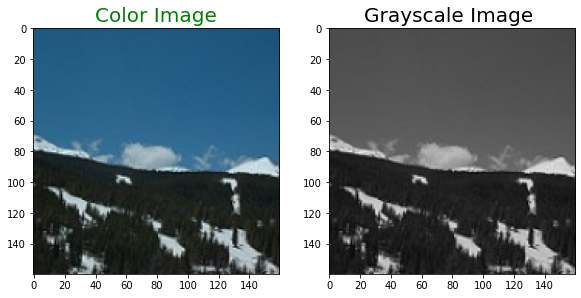

In [ ]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

In [ ]:
train_gray_image = gray_img[:900]
train_color_image = color_img[:900]

test_gray_image = gray_img[900:]
test_color_image = color_img[900:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (900, 160, 160, 3)
Test color image shape (100, 160, 160, 3)


##Model

In [ ]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [ ]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)

    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 80, 80, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 40, 40, 128)  147584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 20, 20, 256)  296192      sequential_1[0][0]               
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error', metrics = ['acc'])

model.fit(train_g, train_c, epochs = 50,batch_size = 50,verbose = 1)

Epoch 1/50
20/20 [==============================] - 253s 13s/step - loss: 0.2554 - acc: 0.3709
Epoch 2/50
20/20 [==============================] - 245s 12s/step - loss: 0.0956 - acc: 0.3551
Epoch 3/50
20/20 [==============================] - 243s 12s/step - loss: 0.0744 - acc: 0.3713
Epoch 4/50
20/20 [==============================] - 243s 12s/step - loss: 0.0671 - acc: 0.4150
Epoch 5/50
20/20 [==============================] - 252s 13s/step - loss: 0.0656 - acc: 0.4201
Epoch 6/50
20/20 [==============================] - 255s 13s/step - loss: 0.0615 - acc: 0.4515
Epoch 7/50
20/20 [==============================] - 257s 13s/step - loss: 0.0614 - acc: 0.4512
Epoch 8/50
20/20 [==============================] - 258s 13s/step - loss: 0.0579 - acc: 0.4437
Epoch 9/50
20/20 [==============================] - 260s 13s/step - loss: 0.0575 - acc: 0.4766
Epoch 10/50
20/20 [==============================] - 257s 13s/step - loss: 0.0576 - acc: 0.4839
Epoch 11/50
20/20 [==============================

In [ ]:
model.evaluate(test_gray_image,test_color_image)

4/4 [==============================] - 12s 3s/step - loss: 0.0299 - acc: 0.6821


[0.02985810488462448, 0.6821441650390625]

##Plotting Results

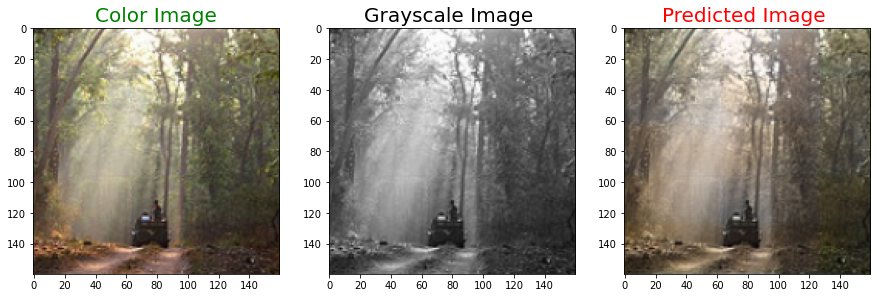

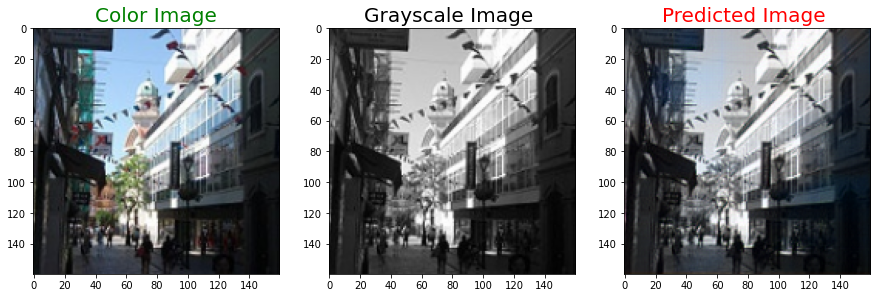

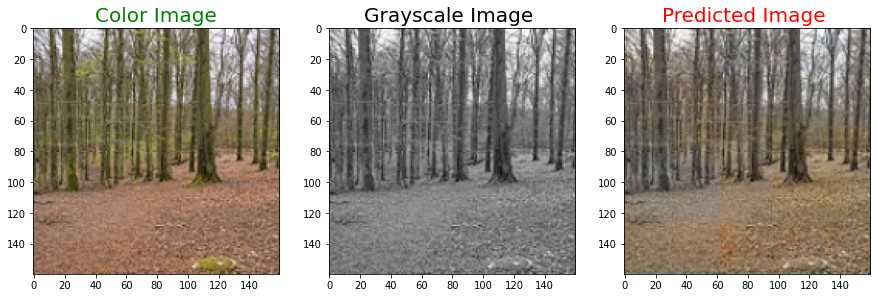

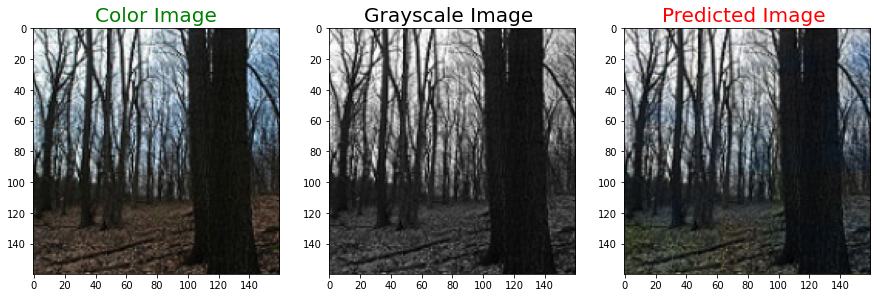

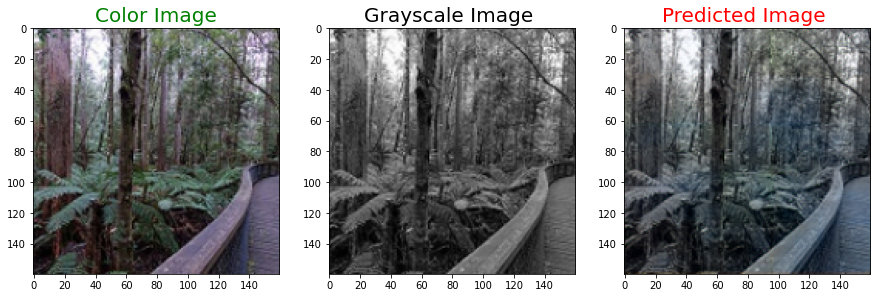

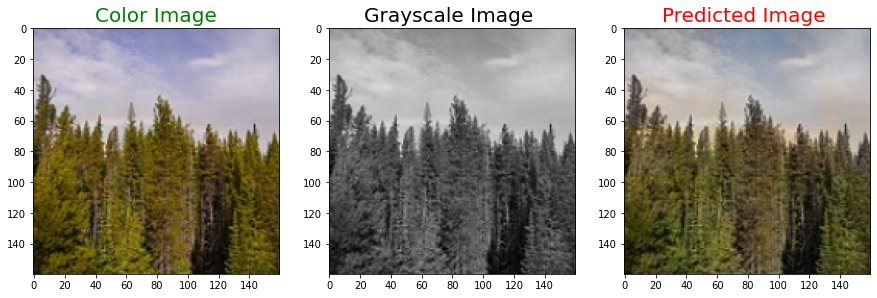

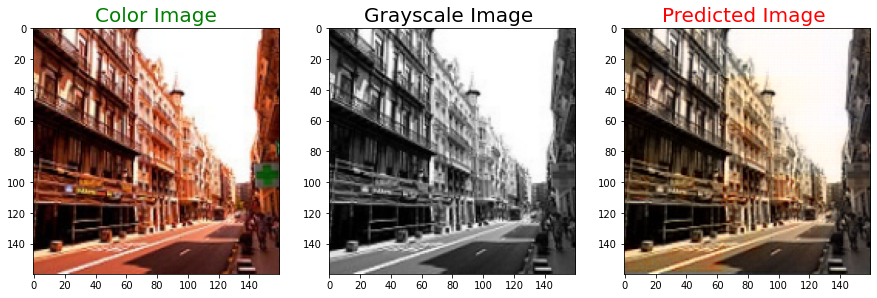

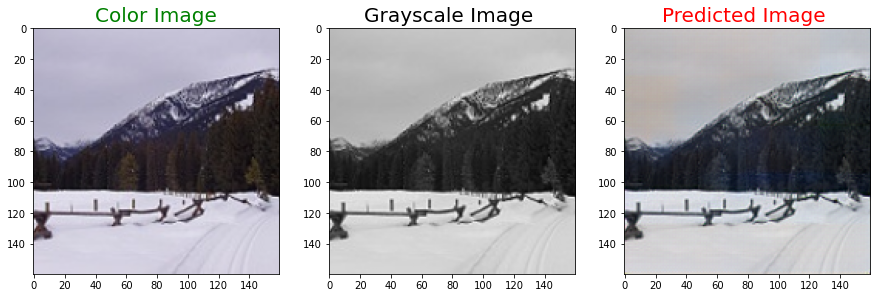

In [ ]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)
